<a href="https://colab.research.google.com/github/mar7i4ka/Lin_Reg/blob/main/Regression_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/DS - lectures/auto-mpg.csv')
df.columns = [col.replace(' ', '_') for col in df.columns]

Тъй като променливата horsepower не е известна за 3 реда от данните и е въведена като '?', премахваме съответните редове.

In [ ]:
df = df[df.horsepower.str.isnumeric()]
df.horsepower = pd.to_numeric(df.horsepower)

In [ ]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [ ]:
df.groupby('origin').horsepower.median()

origin
1    105.0
2     76.5
3     75.0
Name: horsepower, dtype: float64

In [ ]:
df.horsepower = df.horsepower.fillna(10)

##Корелация

Чрез метода corr(), извиквате корелация между всички променливи в дадения DataFrame. Corr() връща коефициент на линейна корелация.

In [ ]:
df.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
model_year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


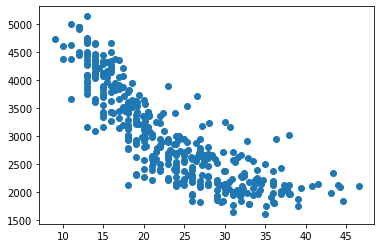

In [ ]:
plt.scatter(df.mpg, df.weight)

Коефициентът на корелация варира между -1 до 1. Отрицателна корелация означава, че при нарастване на едната променлива, другата намалява и обратно. Положителна корелация означава, че и двете промеливи растат, или намаляват заедно. Абсолютната стойност на корелацията показва нейната сила. При корелация 1 (или -1) имаме перфектна линейна връзка между двете променливи - ако ги начертаем една спрямо друга, те ще лежат на една линия. Можем да интерпретираме силата на корелацията както следва: абсолютна стойност 0 - 0.3 - много слабa; 0.3 - 0.5 - слаба към средна; 0.5 - 0.8 средна към силна; 0.8 - 1 силна. (https://www.youtube.com/watch?v=EyMHz5k4SU0)

In [ ]:
from scipy.stats import pearsonr, spearmanr

Scipy връща не само корелация но и P-value (https://www.youtube.com/watch?v=ukcFrzt6cHk). Обяснено накратко: при тестване на хипотези, стандартно различаваме две такива - нулева хипотеза (липса на ефект) и алтернативна хипотеза (наличие на ефект). Когато мерим корелация, нулевата хипотеза е, че няма такава (т.е. корелационният коефициент = 0). Алтернативната е, че корелацията е различна от 0 - т.е. има такава. Тъй като в данните винаги имаме някаква доза несигурност (шум, незнание), използваме вероятност. P стойността е вероятността да наблюдаваме съответния ефект, ако приемем че нулевата хипотеза е правилна. С други думи в дадения пример - имаме вероятност 6.015*10^102 (изключително малко число), да наблюдаваме корелацията от -0.83, ако нулевата хипотеза беше вярна. Ако p < 0.05 стандартно отхвърляме нулевата хипотеза. В случая, това означава, че корелацията ни е значима.

Корелация на Pearson (Линейна корелация)

In [ ]:
pearsonr(df.mpg, df.weight)

(-0.8322442148315753, 6.015296051436822e-102)

Корелация на Spearman (Корелация между ранговете). Корелационният коефициент на Spearman измерва връзка между ранговете на променливите - т.е. ако подредите координатите на всяка една точка от данните веднъж по X и веднъж по Y (първа, втора, трета и т.н.), корелацията е перфектна положителна, ако координатите на първата точка са на първо място и по X и по Y, на втората точка са втори по ранг и т.н. Корелация на Spearman може да се използва при всяка една монотонно нарастваща или намаляваща функция. В случая връзката между променливите има известна нелинейност, следователно получаваме по-силна корелация по Spearman, а не по Pearson.

In [ ]:
spearmanr(df.mpg, df.weight)

SpearmanrResult(correlation=-0.8755851198739869, pvalue=2.662377938025222e-125)

# Линейна регресия

## Simple linear regression - регресия с една променлива

Създаваме обект от класа LinearRegression на sklearn. По подразбиране fit_intercept = True, т.е. sklearn ще добави свободен член към линейната функция. В този случай не е нужно да добавяте колона от единици към вашите данни. Когато използваме statsmodels за регресия, трябва да добавим колона от единици, тъй като sm не добавя свободен член (intercept) имплицитно. Това има предимство, тъй като вие контролирате наличието на такъв.

In [ ]:
lin_reg = LinearRegression(fit_intercept=True)

X е матрица от независими променливи/features (в случая само една), y е вектор от зависимата променлива/target

In [ ]:
y = df.horsepower.to_numpy()
X = df.displacement.to_numpy()

Използваме train_test_split() на sklearn, за да разделим данните на Тренировъчни и Тестови (https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/). Основната причина за това, е че при някои модели (тези, които са по гъвкави/комплексни) можем да достигнем до моделиране на шума в данните - overfitting. Заради това обучаваме модел върху тренинговото множество, и проверяваме колко добре моделът генерализира върху нови, невиждани данни - тестовото множество. Най-общо, ако резултатите са близки, моделът се е справя добре на нови данни.

Използваме random_state, за да можем да репродуцираме данните си. Независимо колко пъти направите train_test_split върху тези данни, ако random_state е един и същ, ще получите еднакви тренингови и тестови множества от данни.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

Експлицитно променяме формата на X, тъй като при наличие на един единствен feature, sklearn изисква той да бъде описан като вектор.

In [ ]:
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

Методът fit() намира най-добрата линия (хиперравнина) при съответните данни.

In [ ]:
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Чрез coef_ и intercept_ можете да извикате съответно коефициентите пред всеки feature в модела и свободния член.

In [ ]:
lin_reg.coef_

array([0.32619517])

In [ ]:
lin_reg.intercept_

40.7060984843082

Използвайки predict(), правим предвиждане с дадения модел. В случая го извикваме с тренировъчните данни, за да видим как изглежда най-добрата линия при тях. След това повтаряме същото с тестовите данни.

In [ ]:
y_hat_train = lin_reg.predict(X_train)

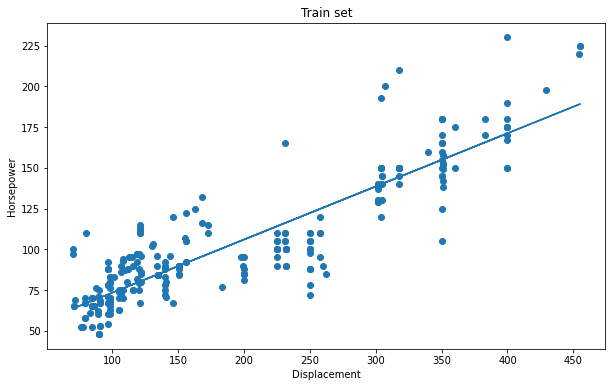

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train)
plt.xlabel('Displacement')
plt.ylabel('Horsepower')
plt.title('Train set')
plt.plot(X_train, y_hat_train)

In [ ]:
y_hat_test = lin_reg.predict(X_test)

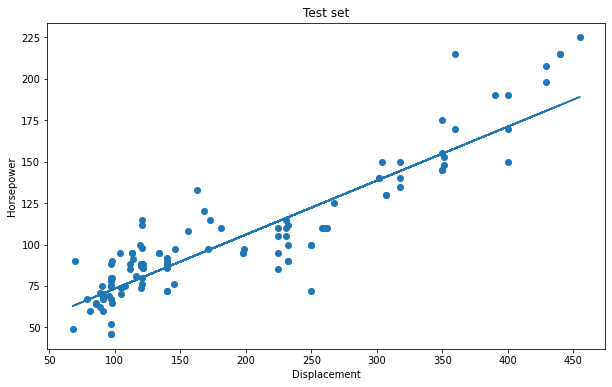

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test)
plt.xlabel('Displacement')
plt.ylabel('Horsepower')
plt.title('Test set')
plt.plot(X_test, y_hat_test)

## Основни метрики при регресия

### $R^{2}$ - коефициент на детерминация (https://www.youtube.com/watch?v=S6AEf9YbScM).

Това е полезна метрика, която варира между 0 и 1 (възможно е и да е под 0, но това е трудно за постигане, ако направим всичко както трябва). 1 означава, че моделът обяснява връзката между променливите перфектно (на практика е почти невъзможно). 0 означава, че моделът изобщо не работи. При извикване на score(), след трениране, можете да видите стойността. В случая имаме доста добър модел.

In [ ]:
lin_reg.score(X_train, y_train)

0.7914033981612862

### MSE - средноквадратична грешка

MSE е средната стойност на квадратичната разлика между предвидените и реалните стойности. Една от най-честно използваните Cost функции при регресионни модели. mean_squared_error() на sklearn връща минимизираната стойност на Cost функцията - т.е. най-малката грешка, която можем да постигнем при нашите данни и съответния модел. MSE може да се използва за сравняване на модели.

In [ ]:
mean_squared_error(y_hat_train, y_train)

302.2414500849854

In [ ]:
mean_squared_error(y_hat_test, y_test)

256.08393432363016

### RMSE - корен квадратен от MSE

RMSE е метрика, която носи малко по-добра интерпретация от MSE. Можем да си я представим като стандартното отклонение, около предвидените стойности (въпреки, че това е валидно само при модел, който описва сравнително точно връзката между feature и target).

In [ ]:
np.sqrt(mean_squared_error(y_hat_train, y_train))

17.385092754569513

### MAE - средна абсолютна грешка

За разлика от MSE, MAE използва абсолютни стойности на грешките, следователно има по-добра интерпретация, поради липсата на квадрати. Стойността по-долу означава очаквана грешка на модела в единиците, в които е Y. Това означава +/- 12.7 единици средна грешка.

In [ ]:
mean_absolute_error(y_hat_train, y_train)

12.716437801495847

### MAPE - средна абсолютна процентна грешка

MAPE има предимството, че изразява грешката в проценти, което би могло да бъде много удобно. Въпреки лесната си интерпретация, често може да бъде подвеждаща.

In [ ]:
np.sum(np.abs((y_hat_train-y_train)/y_train))/274

0.12743959021687398

## Multiple regression - регресия с повече от един feature

In [ ]:
df.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model_year', 'origin', 'car_name'],
      dtype='object')

Не е лоша идея предварително да видим как изглежда връзката между променливите ни чрез scatterplot. pairplot() на seaborn е бърз начин да постигнем това.

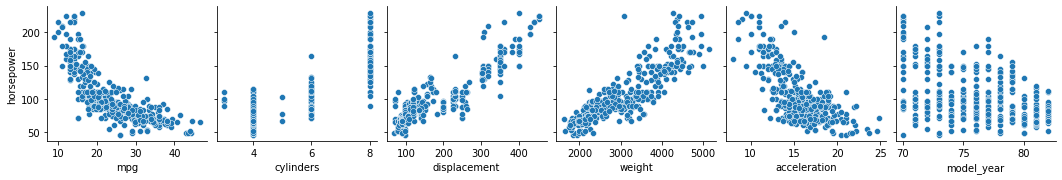

In [ ]:
sns.pairplot(df, x_vars=['mpg', 'cylinders', 'displacement',  'weight',
       'acceleration', 'model_year'], y_vars='horsepower')

Линейният модел е линеен спрямо своите коефициенти. Поради това, на теория можете да трансформирате всяка една променлива и моделът пак е валиден. Т.е. вместо да вземете $y=a.x+b$, можете да сметнете $y=a.f(x) + b$. По долу логаритмуваме променливата mpg, тъй като връзката ѝ с horsepower не изглежда изцяло линейна. Друг вариант е mpg да се вземе на втора степен.

In [ ]:
df['log_mpg'] = np.log(df.mpg)

Тъй като тук ще използваме statsmodels за регресия, експлицитно добавяме вектор с 1 за свободния член в модела.

In [ ]:
df['const'] = 1

Добре е да превърнем категорийни променливи в тип category на Pandas. Така по-долу ги пропускаме при избиране на числов тип данни.

In [ ]:
df.origin = df.origin.astype('category')

Избираме само числови данни.

In [ ]:
mat = df.select_dtypes(['int', 'float'])

In [ ]:
y = mat.horsepower

In [ ]:
X = mat.drop(labels='horsepower', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

При statsmodels OLS() прави стандартна регресия - OLS е ordinary least squares, което е методът за намиране на най-добрата линия/хиперравнина.

In [ ]:
reg = sm.OLS(y_train, X_train).fit()

Предимството на statsmodels при някои модели, е че можем да получим таблицата дадена по-долу. От нея имаме много информация за нашия модел. В случая наблюдаваме добър $R^2$. Допълнително виждаме и Adjusted $R^2$, като е желателно двете стойности да са близки (https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/adjusted-r2/)

In [ ]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             horsepower   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     507.3
Date:                Mon, 08 Nov 2021   Prob (F-statistic):          5.94e-124
Time:                        18:14:21   Log-Likelihood:                -1092.1
No. Observations:                 274   AIC:                             2194.
Df Residuals:                     269   BIC:                             2212.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
mpg             -0.5313      0.186     -2.864   

Както наблюдавахме при корелацията по-горе, и тук имаме p-value. В този случай интерпретацията е подобна - нулевата хипотеза е, че коефициентът пред дадената променлива е 0 (т.е. променливата не влияе на target-a). Алтернативната хипотеза - коефициентът е различен от 0. При p стойност <0.05 можем да приемем, че даденият коефициент е значим за модела. Когато премахвате незначими коефициенти е желателно да го правите един по-един, защото след всяко едно премахване, останалите коефициенти и техните p стойности се променят.